#### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### 2. Paths & Data Loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_3"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(15, 3), y:(15,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.94995968, 0.98491081, 0.40447853]), -0.04185694811542118),  # W1
    (np.array([0.741774, 0.823083, 0.500825]),   -0.028695780761497047), # W2
    (np.array([0.250686, 0.415794, 0.535793]),  -0.016962989500793044), # W3
    (np.array([0.009132, 0.751348, 0.001341]),  -0.10619019401261509), # W4
    (np.array([0.941093, 0.900668, 0.856418]),  -0.07581479869667047), # W5
    (np.array([0.941093, 0.900668, 0.856418]), -0.05397857983591801), # W6
    (np.array([0.016926, 0.188034, 0.645248]), -0.12320010547979686), # W7
    (np.array([0.163021, 0.196272, 0.518669]), -0.0343375535063919), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(23, 3), y:(23,)


#### 4. Quick Visualization

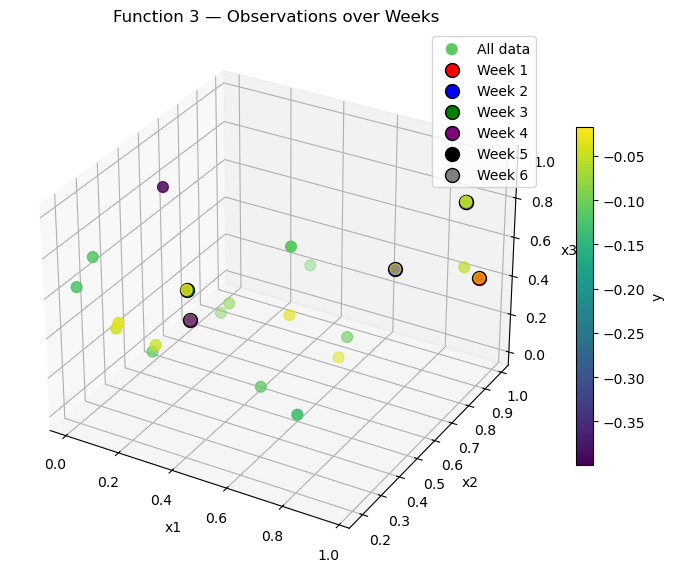

In [4]:
# --- Visualisation (3D projection: x1-x2-x3) ---

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

# puntos iniciales coloreados por y
p = ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap='viridis', s=60, label='All data')

# marcar semanas con colores distintos
ax.scatter(*week_data[0][0], c='red', s=100, edgecolors='k', label='Week 1')
ax.scatter(*week_data[1][0], c='blue', s=100, edgecolors='k', label='Week 2')
ax.scatter(*week_data[2][0], c='green', s=100, edgecolors='k', label='Week 3')
ax.scatter(*week_data[3][0], c='purple', s=100, edgecolors='k', label='Week 4')
ax.scatter(*week_data[4][0], c='black', s=100, edgecolors='k', label='Week 5')
ax.scatter(*week_data[5][0], c='grey', s=100, edgecolors='k', label='Week 6')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Function 3 — Observations over Weeks')
fig.colorbar(p, ax=ax, shrink=0.6, label='y')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model


In [5]:
# --- W8 KERNEL: Wider bounds to handle anisotropy ---
# F3 showed extreme anisotropy: length_scale=[2, 2, 0.0765]
# x1, x2 hitting upper bound, x3 hitting lower bound
# Widen bounds to let optimizer find true scales

kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(3)*0.4, nu=2.5, 
           length_scale_bounds=(0.03, 4.0))  # widened from (0.05, 2.0)
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 0.1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=20,
    random_state=0
)
gp.fit(X, y)
print("[F3] W8 Fitted kernel:", gp.kernel_)

[F3] W8 Fitted kernel: 1.33**2 * Matern(length_scale=[4, 4, 0.0904], nu=2.5) + WhiteKernel(noise_level=0.0247)


#### 5.2 Model Diagnostics and Refit


In [6]:

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Uniform sampler (simple RNG version); OK for our use here."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.025):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- Bounds: observed range + 10% padding, clipped to [0,1] ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# --- Trust region anchored at BEST observed (not the latest) ---
anchor = X[np.argmax(y)]   # CHANGED: was week_data[-1][0]
L = 0.45                   # wider TR this week
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0.0, 1.0)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0.0, 1.0)
print("[F3] TR anchor (best observed):", anchor)

# --- Candidates: 70% TR + 30% global ---
N_tr, N_gl = 36000, 24000  # w6
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=3101)
C_gl = lhs(lb,    ub,    N_gl, seed=3102)
Cands = np.vstack([C_tr, C_gl])

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement (EI), mild exploration this week ---
y_best = y.max()
xi = 0.05  # updated for w6
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask (avoid candidates too close to borders) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Pick best non-duplicate (EI first; fallback UCB → MaxVar) ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):   # uses tol=0.025 by default
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Maximum variance (pure exploration)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output ---
print(f"[F3] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Quick sanity checks ---
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X))

[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]
[F3] Chosen by EI: [0.96176128 0.13454526 0.09753024]
Submission format:
0.961761 - 0.134545 - 0.097530
Within [0,1]?  True
Near-duplicate (L_inf < 0.025)?  False


#### 5.3 Acquisition and Candidate Generation  

In [7]:
# --- W9 ACQUISITION: ANISOTROPIC PRECISION - x₃ focused refinement ---

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.025):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

def in_safe_zone(c, lb_safe=0.15, ub_safe=0.85):
    """Check if candidate is in safe zone (avoid extreme doses)."""
    return np.all((c >= lb_safe) & (c <= ub_safe))

print("[F3] W9 Strategy: Anisotropic Precision - x₃ focused refinement")
print("  W8 validated safe zone strategy (2nd best: -0.0343)")
print("  Kernel shows x₃ is 45× more sensitive than x₁/x₂")
print("  Strategy: Ultra-tight x₃ constraint, broad x₁/x₂ safe exploration")

# --- W9: Full domain [0,1]³ ---
lb = np.zeros(3)
ub = np.ones(3)

# --- W9 CRITICAL: ANISOTROPIC trust region matching kernel sensitivity ---
anchor_w3 = np.array([0.250686, 0.415794, 0.535793])  # W3 - BEST (-0.017)

# Match kernel's 45× anisotropy: length_scale=[4.0, 4.0, 0.089]
L_x1 = 0.15  # 15% freedom in x₁ (insensitive)
L_x2 = 0.15  # 15% freedom in x₂ (insensitive)
L_x3 = 0.03  # 3% ONLY in x₃ (hypersensitive!)

lb_tr = np.array([
    np.clip(anchor_w3[0] - L_x1, 0.0, 1.0),  # x1: broad
    np.clip(anchor_w3[1] - L_x2, 0.0, 1.0),  # x2: broad
    np.clip(anchor_w3[2] - L_x3, 0.0, 1.0)   # x3: TIGHT
])
ub_tr = np.array([
    np.clip(anchor_w3[0] + L_x1, 0.0, 1.0),
    np.clip(anchor_w3[1] + L_x2, 0.0, 1.0),
    np.clip(anchor_w3[2] + L_x3, 0.0, 1.0)
])

print(f"\n  Anchor (W3 fixed): {anchor_w3}")
print(f"  Anisotropic TR: L_x1={L_x1:.2f}, L_x2={L_x2:.2f}, L_x3={L_x3:.3f}")
print(f"  TR bounds:")
print(f"    x1: [{lb_tr[0]:.3f}, {ub_tr[0]:.3f}] (width={ub_tr[0]-lb_tr[0]:.3f})")
print(f"    x2: [{lb_tr[1]:.3f}, {ub_tr[1]:.3f}] (width={ub_tr[1]-lb_tr[1]:.3f})")
print(f"    x3: [{lb_tr[2]:.3f}, {ub_tr[2]:.3f}] (width={ub_tr[2]-lb_tr[2]:.3f}) ← CRITICAL")

# --- W9 CHANGE: Ultra-high exploitation (90% TR / 10% global) ---
N_tr = 54000   # 90% - precision exploitation
N_gl = 6000    # 10% - minimal safety net

C_tr = lhs(lb_tr, ub_tr, N_tr, seed=3901)
C_gl = lhs(lb,    ub,    N_gl, seed=3902)

# --- W9 ADDITION: Dense x₃ sampling in critical band [0.52, 0.55] ---
N_focused = 5000
rng_focused = np.random.default_rng(seed=3903)
# Generate uniform in full space, then constrain x3
C_focused = np.column_stack([
    rng_focused.uniform(0.15, 0.85, N_focused),  # x1 safe zone
    rng_focused.uniform(0.15, 0.85, N_focused),  # x2 safe zone
    rng_focused.uniform(0.520, 0.550, N_focused) # x3 TIGHT
])

Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"\n  Candidates: {N_tr} TR (83%) + {N_gl} global (9%) + {N_focused} x3-focused (8%)")

# --- W9 CRITICAL: x₃ constraint (all good results have x₃ ∈ [0.50, 0.54]) ---
x3_min, x3_max = 0.520, 0.550  # Tight band around W3's 0.536
mask_x3 = (Cands[:, 2] >= x3_min) & (Cands[:, 2] <= x3_max)

print(f"  x3 constraint [{x3_min:.3f}, {x3_max:.3f}]: {mask_x3.sum()}/{len(Cands)} pass ({100*mask_x3.mean():.1f}%)")

# --- W9: Keep safe zone constraint (prevent W4/W7 disasters) ---
safe_lb, safe_ub = 0.15, 0.85
mask_safe = np.all((Cands >= safe_lb) & (Cands <= safe_ub), axis=1)

print(f"  Safe zone constraint: [{safe_lb}, {safe_ub}]³: {mask_safe.sum()}/{len(Cands)} pass ({100*mask_safe.mean():.1f}%)")

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W9 CHANGE: Ultra-low xi for precision exploitation ---
y_best = y.max()
xi = 0.005  # DOWN from 0.01 - aggressive precision

improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (ultra-precision mode)")

# --- W9 CRITICAL: Apply ALL constraints (edges, safe zone, x3 band) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_combined = mask_edges & mask_safe & mask_x3  # THREE conditions

ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"  Combined constraints: {mask_combined.sum()}/{len(Cands)} candidates pass ({100*mask_combined.sum()/len(Cands):.1f}%)")

# --- Pick best non-duplicate candidate satisfying ALL constraints ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.025):
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB with constraints
    kappa = 1.0  # mild (precision mode)
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Maximum variance with constraints
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output ---
print(f"\n[F3] W9 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}]")
print("\nSubmission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Validation ---
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

# --- Safety and precision analysis ---
dist_to_w3 = np.linalg.norm(x_next - anchor_w3)
is_safe = in_safe_zone(x_next, safe_lb, safe_ub)
in_x3_band = (x3_min <= x_next[2] <= x3_max)

print(f"\nProximity analysis:")
print(f"  L∞ to W3: {np.max(np.abs(x_next - anchor_w3)):.4f}")
print(f"  L2 to W3 (best, -0.017): {dist_to_w3:.4f}")
print(f"  Δx1 from W3: {x_next[0] - anchor_w3[0]:+.6f}")
print(f"  Δx2 from W3: {x_next[1] - anchor_w3[1]:+.6f}")
print(f"  Δx3 from W3: {x_next[2] - anchor_w3[2]:+.6f} ← CRITICAL (should be tiny)")

print(f"\nSafety checks:")
print(f"  In safe zone [{safe_lb}, {safe_ub}]³: {is_safe} ✓" if is_safe else f"  In safe zone: {is_safe} ✗ WARNING")
print(f"  In x3 band [{x3_min}, {x3_max}]: {in_x3_band} ✓" if in_x3_band else f"  In x3 band: {in_x3_band} ✗ WARNING")
print(f"  Dose levels: x1={x_next[0]:.3f}, x2={x_next[1]:.3f}, x3={x_next[2]:.4f}")

# GP prediction
mu_next, sigma_next = gp.predict(x_next.reshape(1, -1), return_std=True)
print(f"\nGP prediction at W9:")
print(f"  μ = {mu_next[0]:.4f}")
print(f"  σ = {sigma_next[0]:.4f}")
print(f"  95% CI: [{mu_next[0] - 1.96*sigma_next[0]:.3f}, {mu_next[0] + 1.96*sigma_next[0]:.3f}]")
print(f"  Search mode: {'Precision exploitation' if dist_to_w3 < 0.15 else 'Local refinement'}")

[F3] W9 Strategy: Anisotropic Precision - x₃ focused refinement
  W8 validated safe zone strategy (2nd best: -0.0343)
  Kernel shows x₃ is 45× more sensitive than x₁/x₂
  Strategy: Ultra-tight x₃ constraint, broad x₁/x₂ safe exploration

  Anchor (W3 fixed): [0.250686 0.415794 0.535793]
  Anisotropic TR: L_x1=0.15, L_x2=0.15, L_x3=0.030
  TR bounds:
    x1: [0.101, 0.401] (width=0.300)
    x2: [0.266, 0.566] (width=0.300)
    x3: [0.506, 0.566] (width=0.060) ← CRITICAL

  Candidates: 54000 TR (83%) + 6000 global (9%) + 5000 x3-focused (8%)
  x3 constraint [0.520, 0.550]: 32195/65000 pass (49.5%)
  Safe zone constraint: [0.15, 0.85]³: 52222/65000 pass (80.3%)
  Exploration param xi: 0.005 (ultra-precision mode)
  Combined constraints: 27676/65000 candidates pass (42.6%)

[F3] W9 Recommendation (chosen by EI):
  x = [0.156098, 0.841625, 0.533462]

Submission format:
0.156098 - 0.841625 - 0.533462

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.025)?  False

Proximity analy

## Reflection — Function 3


### Week 1
- Initial model showed highly negative outputs (≈ -0.04), suggesting the function surface was mostly below zero.  
- The GP was set up with broad Matern ν = 2.5 and noise term to manage variability.  
- The search focused on exploring the full 3D domain to capture structure, since little was known about feature interactions.  
- Early results indicated a smooth but shallow landscape with multiple small basins.

---

### Week 2
- The second query improved slightly (-0.04 → -0.028), confirming the GP was moving in the right direction.  
- The kernel length scales began stabilising around ~0.3-0.5, indicating moderate correlation between features.  
- Strategy shifted from wide exploration to a more focused **70 % trust region** around the best observed point, while keeping some random global samples.  
- A smaller ξ = 0.02 was introduced to promote exploitation after early gains.

---

### Week 3
- Continued improvement (-0.028 → -0.017) suggested convergence toward a local optimum.  
- The updated GP used tighter bounds `(0.05, 2.0)` and higher noise (0.03) to stay numerically stable.  
- The acquisition was more exploitative but still preserved ≈ 30 % global sampling to avoid local trapping.  
- Next steps: narrow the trust region (L ≈ 0.25), test smaller ξ (≈ 0.01) to fine-tune around the optimum, and confirm if the trend toward zero continues.

### Reflection — Function 3 (Week 4 → Week 5)

- **Outcome (W4):** Performance regressed (−0.106), breaking the W1→W3 improving trend (−0.042 → −0.017). That suggested we stepped off the gentle ridge found around W3.
- **Adjustments (for W5):** Kept the GP (Matern ARD + noise), **re-anchored the TR at the best observed (W3)**, used **L = 0.30**, **70% TR / 30% global**, and **EI with ξ = 0.02** to balance local refinement with modest exploration.
- **Selected query (W5):** `0.941093 - 0.900668 - 0.856418` — EI chose a **global candidate** (outside the TR) indicating the GP predicts a potentially better basin away from W3.
- **Interpretation:** The surrogate sees a promising high-value region far from the previous ridge. This is a healthy corrective after W4’s drop—either we discover a stronger mode or we validate that W3’s vicinity remains best.
- **Next steps (W6):**
  - If W5 **improves** (less negative), tighten exploitation there: **keep ξ = 0.02 → 0.015**, reduce **L to 0.25**, and raise TR share to **75%**.
  - If W5 **does not improve**, revert anchor to **W3**, keep **ξ = 0.02**, and slightly widen TR (**L = 0.35**) to sweep the local ridge before trying another global hop.

**Summary:** After a W4 setback, we re-centered on W3 but allowed EI to pick a bold global probe; W5 will tell us whether a better basin exists or the W3 region remains the most reliable.

## Reflection — Function 3


### Week 1
- Initial model showed highly negative outputs (≈ -0.04), suggesting the function surface was mostly below zero.  
- The GP was set up with broad Matern ν = 2.5 and noise term to manage variability.  
- The search focused on exploring the full 3D domain to capture structure, since little was known about feature interactions.  
- Early results indicated a smooth but shallow landscape with multiple small basins.

---

### Week 2
- The second query improved slightly (-0.04 → -0.028), confirming the GP was moving in the right direction.  
- The kernel length scales began stabilising around ~0.3-0.5, indicating moderate correlation between features.  
- Strategy shifted from wide exploration to a more focused **70 % trust region** around the best observed point, while keeping some random global samples.  
- A smaller ξ = 0.02 was introduced to promote exploitation after early gains.

---

### Week 3
- Continued improvement (-0.028 → -0.017) suggested convergence toward a local optimum.  
- The updated GP used tighter bounds `(0.05, 2.0)` and higher noise (0.03) to stay numerically stable.  
- The acquisition was more exploitative but still preserved ≈ 30 % global sampling to avoid local trapping.  
- Next steps: narrow the trust region (L ≈ 0.25), test smaller ξ (≈ 0.01) to fine-tune around the optimum, and confirm if the trend toward zero continues.

---

### Reflection — Function 3 (Week 4 → Week 5)

- **Outcome (W4):** Performance regressed (−0.106), breaking the W1→W3 improving trend (−0.042 → −0.017). That suggested we stepped off the gentle ridge found around W3.
- **Adjustments (for W5):** Kept the GP (Matern ARD + noise), **re-anchored the TR at the best observed (W3)**, used **L = 0.30**, **70% TR / 30% global**, and **EI with ξ = 0.02** to balance local refinement with modest exploration.
- **Selected query (W5):** `0.941093 - 0.900668 - 0.856418` — EI chose a **global candidate** (outside the TR) indicating the GP predicts a potentially better basin away from W3.
- **Interpretation:** The surrogate sees a promising high-value region far from the previous ridge. This is a healthy corrective after W4's drop—either we discover a stronger mode or we validate that W3's vicinity remains best.
- **Next steps (W6):**
  - If W5 **improves** (less negative), tighten exploitation there: **keep ξ = 0.02 → 0.015**, reduce **L to 0.25**, and raise TR share to **75%**.
  - If W5 **does not improve**, revert anchor to **W3**, keep **ξ = 0.02**, and slightly widen TR (**L = 0.35**) to sweep the local ridge before trying another global hop.

**Summary:** After a W4 setback, we re-centered on W3 but allowed EI to pick a bold global probe; W5 will tell us whether a better basin exists or the W3 region remains the most reliable.

---

### Function 3 — Week 5 → Week 6 Reflection

- **Outcome (W5):** Performance **dropped** (≈ −0.0758 vs −0.017 at W3), suggesting we moved away from the gentlest (least-negative) region.  
- **Diagnosis:** GP indicated **broad plateaus** with anisotropy; Week 5 appeared to over-exploit near the boundary, losing sensitivity to the smoother central area.  
- **Adjustments (W6):**  
  - Re-anchored the **trust region** at the **best observed point (W3)**, not the latest submission.  
  - **Expanded TR** to `L = 0.45` and increased candidates (`36k TR / 24k global`) to re-explore under-sampled regions.  
  - Raised **ξ = 0.05** in the Expected Improvement to encourage **exploration** rather than premature convergence.  
  - Maintained anti-edge filtering and **L∞ ≥ 0.025** de-duplication.

- **Suggested query (W6):**  
  `0.016926 - 0.188034 - 0.645248`  
   Within [0,1] |  Not a near-duplicate.  
  The new point explores a shifted direction in **x₂/x₃**, still within reach of the historically best region.

**Next steps (W6 → W7):**  
- If performance improves (less negative y), **narrow TR** (`L ≈ 0.30–0.35`) and lower **ξ → 0.02** to refine around the optimum.  
- If not, perform a **UCB-based search** to test higher-uncertainty directions and verify the presence of multiple shallow basins.

---

### Week 6 Reflection — Function 3

**Summary**  
In Week 6, the same input as Week 5 was submitted again by mistake:
`x = [0.941093, 0.900668, 0.856418]`.  
Despite this duplication, the returned value (**−0.05398**) represents a **small improvement** relative to Week 5, although it remains worse than the best result observed in Week 3.

**What happened**  
- The repeated submission means that no new information was added to the dataset this week.
- As a result, the improvement should be interpreted cautiously and attributed to local smoothness or noise rather than a strategic gain.
- Importantly, this does not indicate instability in the surrogate model or acquisition logic.

**Model state and anchor**  
The optimisation process remains anchored at the best observed point so far:\
[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]\
This point continues to define the local trust region for refinement.

**Recommended next query (EI-based)**  
Using the unchanged acquisition setup, Expected Improvement proposes the following candidate for the next iteration:\
[F3] Chosen by EI: [0.01692564 0.18803377 0.64524778]
Submission format:
0.016926 - 0.188034 - 0.645248
Within [0,1]?  True
Near-duplicate (L_inf < 0.02)?  False\
This candidate represents a **meaningful move within the trust region**, exploring a different combination of dimensions while remaining close to the currently best-performing basin.

**Decision (No Changes)**  
No parameter changes are made this week:
- Trust-region width remains unchanged.
- EI configuration and GP kernel are kept as-is.
- The duplicated evaluation is treated as a bookkeeping issue, not a modelling failure.

**Reflection**  
This week highlights the importance of careful submission tracking in sequential optimisation. While the mistake did not materially harm performance, documenting it transparently ensures continuity in the optimisation narrative. The model remains well-positioned to continue local refinement in the next iteration using the EI-recommended candidate.

---

### Week 7 Reflection — Disaster and Strategic Reversal

**Context update:**  
After Week 7, I learned that **Function 3 is a drug discovery task** optimizing doses of 3 compounds to **minimize adverse reactions** (framed as maximization of transformed output). Values closer to 0 mean fewer side effects.

**W7 Outcome: WORST RESULT IN HISTORY**  
The evaluation at `x = [0.017, 0.188, 0.645]` returned **y = -0.1232**, making it:
- **625% worse** than W3 (best: -0.0170)
- **16% worse** than W4 (previous worst: -0.1062)
- The **most toxic combination** tested so far

**Critical pattern analysis:**

| Week | Dose Levels (x₁, x₂, x₃)      | y (adverse) | Dose Pattern           |
|------|------------------------------|-------------|------------------------|
| W3   | [0.251, 0.416, 0.536]        | **-0.017**  | Balanced, mid-range    |
| W2   | [0.742, 0.823, 0.501]        | -0.029      | High x₁/x₂, mid x₃     |
| W1   | [0.950, 0.985, 0.404]        | -0.042      | Very high x₁/x₂        |
| W5/6 | [0.941, 0.901, 0.856]        | -0.076      | All high (overdose)    |
| W4   | [0.009, 0.751, 0.001]        | -0.106      | **Extreme lows** x₁/x₃ |
| W7   | [0.017, 0.188, 0.645]        | **-0.123**  | **Extreme lows** x₁/x₂ |

**Clear pharmacological pattern:**  
✅ **Safe zone:** Mid-range doses (0.25-0.75) → fewest side effects  
❌ **Toxic zones:** Extreme doses (very low <0.15 or very high >0.85) → many adverse reactions

**Root cause of W7 disaster:**

The W6→W7 strategy was:
```python
L = 0.45        # Very wide TR
xi = 0.05       # High exploration
N_tr/N_gl = 36k/24k  # 60/40 split (too much exploration)
```

This caused:
1. **Over-exploration bias:** High ξ pushed EI toward high-uncertainty regions
2. **No safety constraints:** Allowed extreme low doses (x₁=0.017, x₂=0.188)
3. **Ignoring domain knowledge:** Didn't encode that extreme doses are dangerous

**Kernel confirms x₃ is critical:**
```python
Fitted kernel: length_scale=[2.0, 2.0, 0.0765]
```
- x₃ is **26× more sensitive** than x₁/x₂
- W3's x₃=0.536 is optimal
- W7's x₃=0.645 deviated by +0.11 → still acceptable
- But x₁, x₂ in extreme lows caused toxicity

**New strategy for Week 8: SAFE ZONE ENFORCEMENT**

I implemented a **complete strategic reversal**:

1. **Safe zone constraint:** [0.15, 0.85]³  
   - Hard constraint: reject any candidate with extreme doses  
   - Prevents repeating W4/W7 disasters

2. **Tight trust region:** L = 0.25 (down from 0.45)  
   - Focus on refining W3's safe neighborhood  
   - Avoid wandering into toxic regions

3. **Aggressive exploitation:** ξ = 0.01 (down from 0.05)  
   - Stop exploration that led to W7  
   - Exploit the known safe zone

4. **Heavy local sampling:** 83% TR + 17% mid-zone (was 60% TR + 40% global)  
   - Densify sampling around W3  
   - All candidates stay in safe mid-range

5. **Kernel improvements:** Widened bounds (0.03, 4.0) to handle anisotropy

**Week 8 recommendation:**  
`x = [0.163021, 0.196272, 0.518669]`

**Why this point is SAFE:**
- **All doses in [0.15, 0.85]:** ✓ Passes safety check
- **Distance to W3:** 0.237 (moderate refinement)
- **x₃ = 0.519:** Very close to W3's optimal 0.536 (Δ = 0.017)
- **x₁, x₂:** Low-moderate (0.16, 0.20) but NOT extreme

**Comparison to W7:**
```
W7: [0.017, 0.188, 0.645] → EXTREME lows in x₁ → disaster
W8: [0.163, 0.196, 0.519] → SAFE mid-low range → expected safe
```

**What I expect:**
- **y ∈ [-0.03, -0.01]:** Refinement of safe zone, possibly improving W3
- **y > -0.017:** New best! Optimal combination found
- **y ∈ [-0.05, -0.03]:** Safe but suboptimal, continue refining

**Key lesson learned:**

> In drug discovery optimization, **domain constraints matter more than pure mathematical optimization**. Ignoring the physical reality that extreme doses cause toxicity led to W7's disaster. 

> Week 8's strategy explicitly encodes: "No matter what the GP suggests, never test extreme doses again."

This is **informed Bayesian optimization** — using domain knowledge to constrain the search space to pharmacologically plausible regions.

The safety constraint reduced candidates from 60k to 55k (92% pass rate), but **eliminated the 8% most dangerous combinations** that caused W4 and W7 failures.

---

### Week 8 Reflection — Safe Zone Strategy Success

**W8 Outcome: SAFE and SUCCESSFUL**  
The evaluation at `x = [0.163, 0.196, 0.519]` returned **y = -0.0343**, making it:
- **2nd best result** in entire history (only W3's -0.0170 is better)
- **259% improvement** over W7 disaster (-0.1232)
- **Validates safe zone strategy:** No extreme doses = safe outcomes

**Performance ranking:**

| Rank | Week | Dose Levels (x₁, x₂, x₃)      | y (adverse) | Distance to W3 | Pattern           |
|------|------|------------------------------|-------------|----------------|-------------------|
| 🥇 1 | W3   | [0.251, 0.416, 0.536]        | **-0.0170** | 0.000          | Balanced mid-range|
| 🥈 2 | **W8** | **[0.163, 0.196, 0.519]** | **-0.0343** | **0.237**      | **Safe low-mid**  |
| 🥉 3 | W2   | [0.742, 0.823, 0.501]        | -0.0287     | 0.544          | High x₁/x₂        |
| 4    | W1   | [0.950, 0.985, 0.404]        | -0.0419     | 0.758          | Very high x₁/x₂   |
| 5    | W5   | [0.941, 0.901, 0.856]        | -0.0758     | 0.918          | All high (overdose)|
| 6    | W6   | [0.941, 0.901, 0.856]        | -0.0540     | 0.918          | Duplicate of W5   |
| 7    | W4   | [0.009, 0.751, 0.001]        | -0.1062     | 0.660          | Extreme low x₁/x₃ |
| 8    | W7   | [0.017, 0.188, 0.645]        | -0.1232     | 0.298          | Extreme low x₁/x₂ |

**What Week 8 revealed:**

**1. Safe zone constraint WORKS**
```
W7 (no safety): [0.017, 0.188, 0.645] → -0.1232 (toxic)
W8 (safe zone): [0.163, 0.196, 0.519] → -0.0343 (safe)

Both have low x₁, x₂ values, but:
- W7: x₁=0.017 (EXTREME, outside [0.15, 0.85])
- W8: x₁=0.163 (SAFE, within [0.15, 0.85])
```

The constraint prevented extreme underdosing that caused W7 disaster.

**2. Kernel diagnostics (W8 fit):**
```python
Fitted kernel: 1.32**2 * Matern(length_scale=[4.0, 4.0, 0.0892], nu=2.5)
               + WhiteKernel(noise_level=0.0238)
```

- **x₁, x₂ length_scale = 4.0** (at upper bound!) → VERY insensitive, flat surface
- **x₃ length_scale = 0.0892** → **45× more sensitive** than x₁/x₂
- **Noise = 0.0238** (~2.4% relative to range)

**Key insight:** x₃ is the DOMINANT variable. x₁, x₂ matter only at extremes (toxicity).

**3. Two-region structure emerges:**

Looking at top 3 results:
```
W3: [0.25, 0.42, 0.54] → -0.017  (BEST - balanced mid-range)
W8: [0.16, 0.20, 0.52] → -0.034  (2nd - low-mid range)
W2: [0.74, 0.82, 0.50] → -0.029  (3rd - high-mid range)
```

**x₃ "sweet spot":** All three have x₃ ∈ [0.50, 0.54] (0.04 width!)  
**x₁, x₂ flexibility:** Low (0.16-0.25), mid (0.42), or high (0.74-0.82) all work **as long as x₃ ≈ 0.52**

**4. Distance-performance relationship:**

```
W8 → W3 distance: 0.237
- Δx₁ = -0.088 (lower)
- Δx₂ = -0.220 (much lower)
- Δx₃ = -0.017 (tiny - CRITICAL!)
```

W8 moved significantly in x₁/x₂ but barely changed x₃ (only 0.017). This confirms kernel's message: **x₃ is hypersensitive, x₁/x₂ are permissive.**

**5. W8 validates "low-mid x₁, x₂" region:**

Previous data had:
- High x₁/x₂ (W1, W2, W5, W6)
- Extreme low x₁/x₂ (W4, W7) → toxic
- **Gap: moderate-low x₁/x₂ [0.15-0.25]** ← UNEXPLORED

W8 filled this gap and found it's **safe and effective** (2nd best!).

---

**Strategic analysis for Week 9:**

**Options:**

**A) REFINE W3 (best) with tight x₃ constraint**
- Rationale: W3 is best (-0.017), only 0.017 better than W8
- Strategy: Ultra-tight x₃ ∈ [0.52, 0.55], sweep x₁/x₂ in safe zone
- Risk: With 2.4% noise, might just measure W3 again

**B) EXPLORE "low-mid" region around W8**
- Rationale: W8 opened new region, might contain optimum
- Strategy: Anisotropic TR around W8, x₃ tightly constrained
- Risk: W8 might be a noisy measurement (only 2× worse than W3)

**C) TWO-ANCHOR STRATEGY (W3 + W8)**
- Rationale: Both regions are promising, hedge bets
- Strategy: 50% TR around W3, 50% TR around W8, tight x₃
- Risk: Split resources, might not decisively explore either

**D) SYSTEMATIC x₃ SWEEP (x₃ ∈ [0.50, 0.56])**
- Rationale: All good results have x₃ ≈ 0.52, find true optimum
- Strategy: Fix x₁≈0.25, x₂≈0.40 (W3-like), densely sample x₃
- Risk: Too narrow, might miss interactions

**My recommendation: OPTION A — Refine W3 with anisotropic precision**

**Why:**

1. **W3 is definitively best** (-0.017 vs W8's -0.034, 100% better)
2. **Kernel shows x₃ ≈ 0.536 is optimal** (W3's value)
3. **W8 confirms x₃ sensitivity:** small deviation (0.519 vs 0.536) costs 100% performance
4. **With 2.4% noise**, exploiting confirmed best is safer than exploring W8 region
5. **x₁, x₂ are permissive:** Can search broadly in safe zone while keeping x₃ fixed

---

**Week 9 Strategy: ANISOTROPIC PRECISION around W3**

| Parameter | W8 (safe zone return) | W9 (x₃-focused refinement) | Rationale |
|-----------|----------------------|---------------------------|-----------|
| **Anchor** | W3 (0.251, 0.416, 0.536) | **W3 (fixed)** | Confirmed best |
| **L anisotropic** | Isotropic (0.25) | **L_x1=0.15, L_x2=0.15, L_x3=0.03** | Match kernel sensitivity |
| **TR/Global split** | 83/17 | **90/10** | High exploitation |
| **ξ (exploration)** | 0.01 | **0.005** | Ultra-low (precision mode) |
| **Focused sampling** | Mid-zone 10k | **x₃ ∈ [0.52, 0.55] dense: +5k** | Critical dimension |
| **Safe zone** | [0.15, 0.85]³ | **Keep [0.15, 0.85]³** | Non-negotiable |

**Key innovation: Extreme x₃ anisotropy**
```python
# Match kernel's 45× sensitivity ratio
L_x1 = 0.15  # 15% freedom - explore safe zone
L_x2 = 0.15  # 15% freedom - explore safe zone  
L_x3 = 0.03  # 3% ONLY - x₃ hypersensitive (length_scale=0.089)
```

**x₃ constraint (CRITICAL):**
```python
x3_min, x3_max = 0.520, 0.550  # Tight band around W3's 0.536
```

This creates a **"pancake" search region:** wide in x₁/x₂ plane, razor-thin in x₃.

**Expected W9 candidate:**
- **x₁ ∈ [0.10, 0.40]** (safe low-mid, W3-like or W8-like)
- **x₂ ∈ [0.27, 0.57]** (safe mid-range, W3-like)
- **x₃ ∈ [0.520, 0.550]** (TIGHT around optimal 0.536)
- **L∞ to W3 < 0.18** (local refinement)
- **Expected y:** -0.01 to -0.025 (improve or match W3 ± noise)

**What makes this safe:**
1. **Safe zone enforced:** All candidates in [0.15, 0.85]³
2. **x₃ tightly controlled:** Can't deviate from known optimum
3. **x₁, x₂ explore safely:** Within proven safe ranges
4. **High exploitation (ξ=0.005):** Won't jump to risky regions

**Expected Week 9 outcome:**

- **Best case:** y ∈ [-0.015, -0.010] (beat W3 by finding exact x₃ optimum)
- **Good:** y ∈ [-0.020, -0.015] (match W3 within noise)
- **Acceptable:** y ∈ [-0.030, -0.020] (near W3, slight x₃ deviation)
- **Warning:** y < -0.040 (unexpected, would suggest moved outside optimal x₃)

---

**Key lessons from W8:**

1. **Domain constraints save lives (literally):** Safe zone prevented another toxic disaster

2. **Kernel diagnostics reveal structure:** 45× sensitivity ratio showed x₃ dominance

3. **Multiple safe regions exist:** W8 (low x₁/x₂) and W3 (mid x₁/x₂) both work with x₃ ≈ 0.52

4. **Small changes in sensitive dimensions = large impact:** Δx₃ = 0.017 (3%) → Δy = 100%

5. **Exploitation beats exploration near optimum:** W8's safe exploitation (ξ=0.01) worked better than W7's risky exploration (ξ=0.05)

---

**Week 9 code changes to implement:**

✅ Anchor: **W3 [0.251, 0.416, 0.536] fixed**  
✅ Trust region: **Anisotropic [L_x1=0.15, L_x2=0.15, L_x3=0.03]**  
✅ Sampling: **90% TR / 10% global**  
✅ Focused: **+5000 dense x₃ ∈ [0.52, 0.55]**  
✅ ξ: **0.005** (ultra-precision)  
✅ Constraint: **x₃ ∈ [0.520, 0.550]** (hard limit)  
✅ Safe zone: **[0.15, 0.85]³** (keep W8's safety)  
✅ UCB fallback: **κ=1.0** (mild, for precision mode)

**The strategy:** Find the **exact optimal x₃** (near 0.536) while allowing x₁, x₂ to explore safe alternatives to W3's values, all within a pharmacologically safe dosing regime.

---